### Demo of Single Photon Emission Computerized Tomography (SPECT) using Maximum Likelihood Expectation Maximization (MLEM)

This page is a PyTorch translation of the SPECTrecon.jl documentation: 
https://juliaimagerecon.github.io/SPECTrecon.jl/stable/generated/examples/

Packages needed here:

In [1]:
import sys
[sys.path.append(i) for i in ['.', '..']]
from mirtorch.linear.spect import SPECT
import torch
import math
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

ModuleNotFoundError: No module named 'util'

Generate simulation data:

In [2]:
nx, ny, nz = 64, 64, 50
xtrue = torch.zeros(nx, ny, nz)
xtrue[(nx//4):(2*nx//3), ny//5:(3*ny//5), 2*nz//6:(3*nz//6)] = 1
xtrue[(2*nx//5):(3*nx//5), ny//5:(2*ny//5), 4*nz//6:(5*nz//6)] = 2

Text(0.5, 0.98, 'true image')

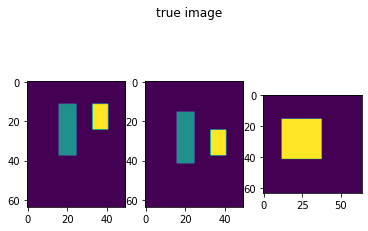

In [3]:
fig, axs = plt.subplots(1,3)
axs[0].imshow(xtrue[nx//2, :, :])
axs[1].imshow(xtrue[:, ny//4, :])
axs[2].imshow(xtrue[:, :, nz//3])
plt.suptitle('true image')

Generate attenuation map: here we use a random attenuation for simplicity, in practice the attenuation map comes from the CT.

In [4]:
mumap = 0.01 * torch.rand_like(xtrue)

Generate point spread function (PSF): In general the PSF can vary from view to view due to non-circular detector orbits. For simplicity, here we illustrate the case where the PSF is the same for every view and every depth.


In [5]:
nview = 60
kernel_size = 7
sigma = 3

# Create a x, y coordinate grid of shape (kernel_size, kernel_size, 2)
x_cord = torch.arange(kernel_size)
x_grid = x_cord.repeat(kernel_size).view(kernel_size, kernel_size)
y_grid = x_grid.t()
xy_grid = torch.stack([x_grid, y_grid], dim=-1)

mean = (kernel_size - 1)/2.
variance = sigma**2.

# Calculate the 2-dimensional gaussian kernel which is
# the product of two gaussian distributions for two different
# variables (in this case called x and y)
gaussian_kernel = (1./(2.*math.pi*variance)) *\
                  torch.exp(
                      -torch.sum((xy_grid - mean)**2., dim=-1) /\
                      (2*variance)
                  )
# Make sure sum of values in gaussian kernel equals 1.
gaussian_kernel = gaussian_kernel / torch.sum(gaussian_kernel)
psf = gaussian_kernel.repeat(ny,nview,1,1).permute(2,3,0,1)

Text(0.5, 0.98, 'point spread functions')

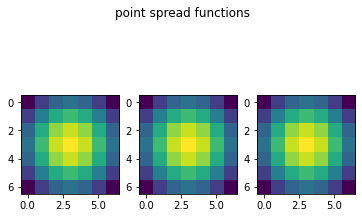

In [6]:
# same psf for each depth and view angle
fig, axs = plt.subplots(1,3)
axs[0].imshow(psf[:, :, 0, 0])
axs[1].imshow(psf[:, :, 30, 0])
axs[2].imshow(psf[:, :, 0, 30])
plt.suptitle('point spread functions')

Basic MLEM algorithm: MLEM is a classic algorithm for performing SPECT image reconstruction

In [7]:
dy = 8
A = SPECT(size_in=(nx, ny, nz), size_out=(nx, nz, nview), 
          mumap=mumap, psfs=psf, dy=dy)
ytrue = A * xtrue
target_mean = 30 # aim for mean of 20 counts per ray
scale = target_mean / torch.mean(ytrue)
scatter_fraction = 0.1 # 10% uniform scatter for illustration
scatter_mean = scatter_fraction * torch.mean(ytrue) # uniform for simplicity
background = scatter_mean * torch.ones(nx,nz,nview)
ynoisy = torch.poisson(scale * (ytrue + background)) / scale

Text(0.5, 0.98, 'true projections')

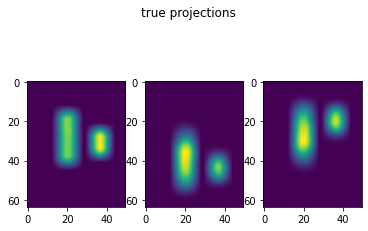

In [8]:
fig, axs = plt.subplots(1,3)
axs[0].imshow(ytrue[:, :, 0])
axs[1].imshow(ytrue[:, :, 20])
axs[2].imshow(ytrue[:, :, 40])
fig.suptitle('true projections')

Text(0.5, 0.98, 'noisy projections')

<Figure size 432x288 with 0 Axes>

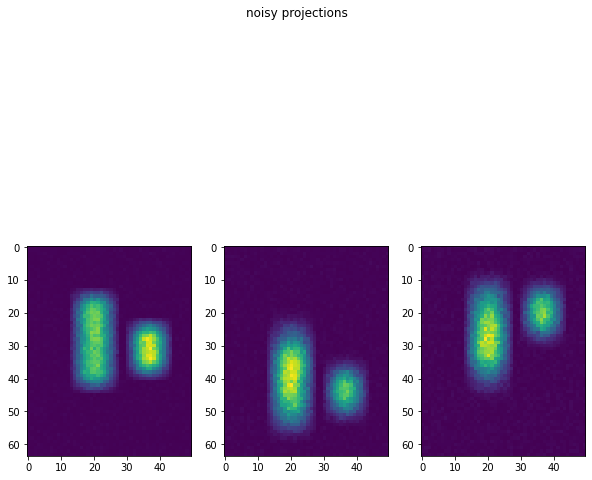

In [9]:
plt.figure()
fig, axs = plt.subplots(1,3)
fig.set_figheight(10)
fig.set_figwidth(10)
axs[0].imshow(ynoisy[:, :, 0])
axs[1].imshow(ynoisy[:, :, 20])
axs[2].imshow(ynoisy[:, :, 40])
fig.suptitle('noisy projections')

In [10]:
def mlem(x, ynoisy, background, SPECT_sys, niter=20):
    assert torch.min(background) > 0
    asum = SPECT_sys._apply_adjoint(torch.ones_like(ynoisy))
    asum[asum == 0] = float('Inf')
    out = torch.clone(x)
    for iter in range(niter):
        ybar = SPECT_sys._apply(out)
        yratio = torch.div(ynoisy, ybar + background)
        back = SPECT_sys._apply_adjoint(yratio)
        out = torch.multiply(out, torch.div(back, asum))
    return out

In [11]:
x0 = torch.ones(nx, ny, nz) # initial uniform image
# MLEM reconstruction after 20 iterations
xhat1 = mlem(x=x0, ynoisy=ynoisy, background=background, SPECT_sys=A)

Text(0.5, 0.98, 'MLEM reconstruction')

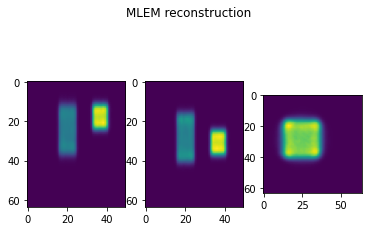

In [12]:
fig, axs = plt.subplots(1,3)
axs[0].imshow(xhat1[nx//2, :, :])
axs[1].imshow(xhat1[:, ny//4, :])
axs[2].imshow(xhat1[:, :, nz//3])
plt.suptitle('MLEM reconstruction')

Unrolled regularized expectation-maximization (reg-EM) is another algorithm for performing SPECT image reconstruction. This page considers regularizers of the form $\frac{\beta}{2}\|x-u\|^2$, where $u$ is an auxiliary variable that often refers to the image denoised by a convolutional neural network (CNN) [1].


[1] Z. Li, Y. K. Dewaraja and J. A. Fessler, "Training End-to-End Unrolled Iterative Neural Networks for SPECT Image Reconstruction," in IEEE Transactions on Radiation and Plasma Medical Sciences, vol. 7, no. 4, pp. 410-420, April 2023, doi: 10.1109/TRPMS.2023.3240934.

In [13]:
def regem(x, ynoisy, background, net, Asum, SPECT_sys, beta, niter=20):
    """regularized EM algorithm for SPECT image reconstruction

    Args:
        x (torch tensor): input image
        ynoisy (torch tensor): total projection
        background (torch tensor): scatter estimates
        net (torch DL model): neural network
        Asum (torch tensor): T'*A'*1
        SPECT_sys (LinearMap): SPECT system matrix
        beta (float): regularization parameter
        niter (int, optional): number of iterations. Defaults to 20.
    """
    assert torch.min(background) > 0
    u = net.forward(x.unsqueeze(0).unsqueeze(0)).squeeze() + x # residual learning
    Asumu = Asum - beta * u
    Asumu2 = torch.square(Asumu)
    for _ in range(niter):
        ybar = SPECT_sys._apply(x) + background
        yratio = torch.div(ynoisy, ybar)
        eterm = SPECT_sys._apply_adjoint(yratio)
        eterm_beta = 4 * beta * torch.mul(x, eterm)
        x = F.relu((torch.sqrt(Asumu2 + eterm_beta) - Asumu) / (2 * beta), inplace=True)
    return x

Define a simple four-layer convolutional neural network

In [14]:
class Net(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.conv1 = nn.Conv3d(in_channels=1, out_channels=16,
                               kernel_size=(3,3,3), stride=(1,1,1),
                               padding=(1,1,1))
        self.conv2 = nn.Conv3d(in_channels=16, out_channels=32,
                               kernel_size=(3,3,3), stride=(1,1,1),
                               padding=(1,1,1))
        self.conv3 = nn.Conv3d(in_channels=32, out_channels=16,
                               kernel_size=(3,3,3), stride=(1,1,1),
                               padding=(1,1,1))
        self.conv4 = nn.Conv3d(in_channels=16, out_channels=1,
                               kernel_size=(3,3,3), stride=(1,1,1),
                               padding=(1,1,1))
    def forward(self, x):
        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))
        out = self.conv4(out)
        return out

Let's use mean squared error (MSE) loss for training the neural network and ADAMW.

In [15]:
net = Net()
criterion = nn.MSELoss()
optimizer = optim.AdamW(net.parameters(), lr=1e-3)

Train the network: We simply feed the data through regularized EM for one iteration, and backpropagate from the very last iteration output.

In [16]:
Asum = A._apply_adjoint(torch.ones_like(ynoisy))
nepoch = 50
ninner = 1
beta = 5
net.train()
for epoch in range(nepoch):
    optimizer.zero_grad()
    xhat2 = regem(x=xhat1, ynoisy=ynoisy, background=background, 
                      net=net, Asum=Asum, SPECT_sys=A, beta=beta, niter=ninner)
    loss = criterion(xhat2, xtrue)
    loss.backward()
    optimizer.step()   
    print(f'epoch: {epoch+1}, loss: {loss.item():.5f}')   

epoch: 1, loss: 0.00574
epoch: 2, loss: 0.00569
epoch: 3, loss: 0.00563
epoch: 4, loss: 0.00555
epoch: 5, loss: 0.00543
epoch: 6, loss: 0.00529
epoch: 7, loss: 0.00522
epoch: 8, loss: 0.00503
epoch: 9, loss: 0.00492
epoch: 10, loss: 0.00485
epoch: 11, loss: 0.00477
epoch: 12, loss: 0.00478
epoch: 13, loss: 0.00471
epoch: 14, loss: 0.00469
epoch: 15, loss: 0.00461
epoch: 16, loss: 0.00458
epoch: 17, loss: 0.00454
epoch: 18, loss: 0.00452
epoch: 19, loss: 0.00449
epoch: 20, loss: 0.00445
epoch: 21, loss: 0.00442
epoch: 22, loss: 0.00438
epoch: 23, loss: 0.00436
epoch: 24, loss: 0.00431
epoch: 25, loss: 0.00430
epoch: 26, loss: 0.00425
epoch: 27, loss: 0.00423
epoch: 28, loss: 0.00420
epoch: 29, loss: 0.00415
epoch: 30, loss: 0.00412
epoch: 31, loss: 0.00409
epoch: 32, loss: 0.00406
epoch: 33, loss: 0.00403
epoch: 34, loss: 0.00398
epoch: 35, loss: 0.00395
epoch: 36, loss: 0.00391
epoch: 37, loss: 0.00386
epoch: 38, loss: 0.00382
epoch: 39, loss: 0.00379
epoch: 40, loss: 0.00375
epoch: 41

Let's do testing now.

Text(0.5, 0.98, 'Unrolled reg-EM reconstruction')

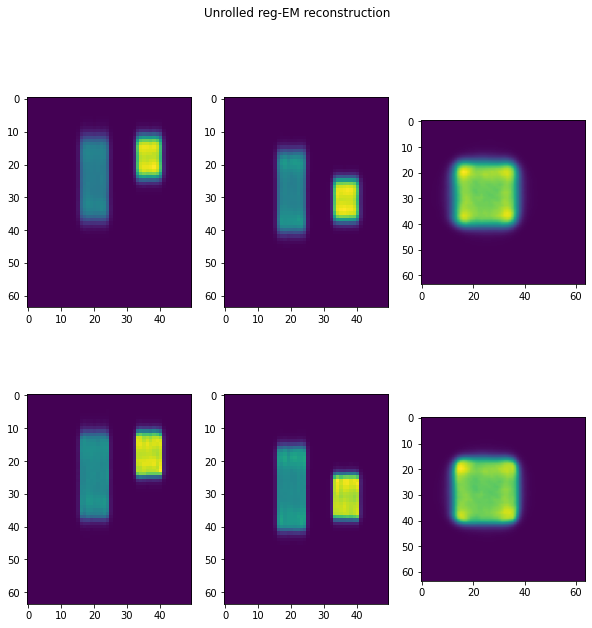

In [19]:
net.eval()
xhat1_test = torch.clone(xhat1)
with torch.no_grad():
    xhat2_test = regem(x=xhat1_test, ynoisy=ynoisy, background=background, 
                      net=net, Asum=Asum, SPECT_sys=A, beta=beta, niter=ninner)
        
fig, axs = plt.subplots(2,3)
fig.set_figheight(10)
fig.set_figwidth(10)
axs[0,0].imshow(xhat1_test[nx//2, :, :])
axs[0,1].imshow(xhat1_test[:, ny//4, :])
axs[0,2].imshow(xhat1_test[:, :, nz//3])
axs[1,0].imshow(xhat2_test[nx//2, :, :])
axs[1,1].imshow(xhat2_test[:, ny//4, :])
axs[1,2].imshow(xhat2_test[:, :, nz//3])
plt.suptitle('Unrolled reg-EM reconstruction')

Now do some quantitative comparisons:

In [18]:
def nrmse(x, xhat):
    return torch.norm(x.flatten() - xhat.flatten()) / torch.norm(xhat.flatten())
nrmse_xhat1_test = nrmse(xhat1_test, xtrue).item()
nrmse_xhat2_test = nrmse(xhat2_test, xtrue).item()
print(f'MLEM NRMSE: {nrmse_xhat1_test:.2f}, CNN reg-EM NRMSE: {nrmse_xhat2_test:.2f}')

MLEM NRMSE: 0.32, CNN reg-EM NRMSE: 0.25
